In [ ]:
#Imports
%matplotlib inline
import pandas as pd
import numpy as np
import math
import matplotlib.pylab as plt
import os
import tensorflow as tf
from tensorflow import keras
from keras.layers import Dropout
import pydot

import warnings
warnings.filterwarnings('ignore')
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' #INFO and WARNING messages are not printed
import time

In [ ]:
##Load data
# PAULA: MODIFICAR DIRECTORIO
# Set working directory
# os.chdir("C:\Users\migue\OneDrive\Escritorio\Postgrado\Capstone\HM_interactions.csv")
# interactions=pd.read_csv('gdrive/My Drive/POSTGRADO DATA SCIENCE/HM_interactions.csv')
# interactions

# Load Transactions Data
interactions=pd.read_csv('HM_interactions.csv')
interactions

,customer_id,article_id,timestamp,price,sales_channel_id
0,10054,5498,1590278400,0.033881,2
1,8612,4092,1599177600,0.013542,2
2,12973,4109,1591401600,0.013542,1
3,9820,12918,1593820800,0.045763,2
4,3329,1739,1578355200,0.011847,2
...,...,...,...,...,...
382317,12873,18345,1587772800,0.013542,2
382318,1010,11221,1590710400,0.018390,1
382319,8493,13473,1592784000,0.027102,2
382320,7232,4383,1592179200,0.008458,2


In [ ]:
#Test set creation

# convert timestamp to datetime
interactions['timestamp'] = pd.to_datetime(interactions['timestamp'], unit='s')
# sort by date, group by customer_id and choose the most recent
interactions_sorted = interactions.sort_values(['timestamp'],ascending=True).groupby('customer_id').tail(1)
#  we create the test_set with the most recent purchase
test_set = interactions_sorted[['customer_id', 'article_id']].copy()
# add "interactions" column
test_set['interaction']='1'
test_set

,customer_id,article_id,interaction
319836,10326,8018,1
281185,793,5074,1
180657,12364,2963,1
109977,13172,8425,1
215504,1448,16219,1
...,...,...,...
237780,12764,18546,1
52476,10109,19752,1
233469,2014,186,1
135052,3816,18559,1


In [ ]:
# Train set creation

# rows to be dropped are selectect (test_set) 
rows_to_drop = list(test_set.index.values)
# rows are dropped
pre_train_set = interactions.drop(rows_to_drop)
# order interactions by clients
pre_train_set = pre_train_set.sort_values(by=['customer_id'])
#we select "customer_id" and "article_id" columns and add interactions column
pre_train_set = pre_train_set[['customer_id', 'article_id']].copy()
# add interaction column
pre_train_set['interaction'] = 1
pre_train_set

,customer_id,article_id,interaction
230101,0,18669,1
372895,0,1367,1
168837,0,11649,1
291870,0,18373,1
217925,0,4915,1
...,...,...,...
3059,13358,17493,1
353592,13358,19924,1
237570,13358,326,1
9946,13358,12890,1


In [ ]:
# Negative sampling

#transform to numpy for sampling
trans_matrix=pd.DataFrame(pre_train_set).to_numpy()

# Client's list
customer_list=np.array(np.unique(trans_matrix[:,0]))
customer_list

array([    0,     1,     2, ..., 13356, 13357, 13358], dtype=int64)

In [ ]:
# negative sampling loop
negative_sampling_all=np.empty((0, 3), int)
for i in range(np.size(customer_list)):
  # save all articles bought by the i-th client
  find=trans_matrix[np.where(trans_matrix[:,0] == customer_list[i])][:,1]
  # we save 4 random articles not bought by the i-th customer
  notfind=np.random.choice(trans_matrix[trans_matrix[:,0]!=i][:,1],4*np.size(find))
  create_notfind=np.column_stack((np.transpose(np.full(np.size(trans_matrix[trans_matrix[:,0]==customer_list[i]][:,0])*4,customer_list[i])), np.transpose(notfind),np.zeros(np.size(trans_matrix[trans_matrix[:,0]==customer_list[i]][:,0])*4)))
  # train_set generation
  negative_sampling=np.concatenate((trans_matrix[trans_matrix[:,0]==customer_list[i]], create_notfind))
  negative_sampling_all = np.concatenate((negative_sampling_all,negative_sampling))

In [ ]:
# convert to dataframe
train_set = pd.DataFrame(negative_sampling_all, columns = ['customer_id','article_id','interaction'])
train_set=train_set.astype(int)
customer0=train_set[train_set.customer_id==0]
customer0[customer0.interaction==0]
train_set

,customer_id,article_id,interaction
0,0,18669,1
1,0,1367,1
2,0,11649,1
3,0,18373,1
4,0,4915,1
...,...,...,...
1844810,13358,3606,0
1844811,13358,13105,0
1844812,13358,2500,0
1844813,13358,4907,0


In [ ]:
# Load model from h5 file

my_model = keras.models.load_model('my_model/my_model_12_d')
my_model.load_weights("my_model/weights_12_d.h5")

In [ ]:
#Model implementation with keras

N = interactions.customer_id.unique() #Number of customers in the data
M = interactions.article_id.unique() #Number of articles in the data
n_users, n_item = len(N), len(M)

n_latent_factors = 64 #Latent factors; K must be a power of two

#articles input
item_input = keras.layers.Input(shape=[1],name='Item')
#articles embedding
item_embedding = keras.layers.Embedding(n_item + 1, n_latent_factors, name='Item-Embedding')(item_input)
#articles vector
item_vec = keras.layers.Flatten(name='FlattenItems')(item_embedding)
#customer input
user_input = keras.layers.Input(shape=[1],name='User')
#customer embedding
user_embedding = keras.layers.Embedding(n_users + 1, n_latent_factors,name='User-Embedding')(user_input)
#customer vector
user_vec = keras.layers.Flatten(name='FlattenUsers')(user_embedding)
#dot product
prod = keras.layers.dot([item_vec, user_vec], axes=1,name='DotProduct')
#add dropout to avoid overfitting
drop = keras.layers.Dropout(0.2, name='Dropout')(prod)
#add Sigmoid activation function to normalize outputs from 0 to 1
act = keras.layers.Dense(1, activation='sigmoid', name='Activation')(drop)

#generate the model
model = keras.Model([user_input, item_input], drop)

In [ ]:
#compile the model
#Adam Optimizer uses GD; BCE as loss function 
model.compile(optimizer='Adam', loss='binary_crossentropy')
#visualize model
tf.keras.utils.plot_model(model, to_file='model.png')

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.


The time of execution of above program (in minutes) is : 479.69436358213426


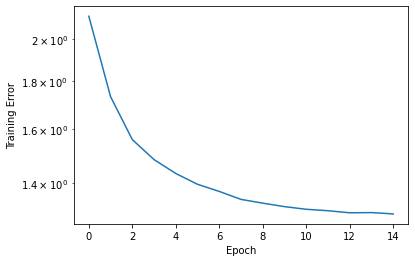

In [ ]:
start_time = time.time()
#train the model
history = model.fit([train_set.customer_id, train_set.article_id], train_set.interaction, epochs=12, verbose=0)
pd.Series(history.history['loss']).plot(logy=True)
plt.xlabel("Epoch")
plt.ylabel("Training Error")

end_time = time.time()
 
print("The time of execution of above program (in minutes) is :", (end_time - start_time)/60)

In [ ]:
# Save keras model in h5 file
# model.save("modelname")
# model.save_weights("weightsname.h5")

INFO:tensorflow:Assets written to: my_model_15_0.2\assets


INFO:tensorflow:Assets written to: my_model_15_0.2\assets


In [ ]:
#Example of one learnt article embedding with k latent factors
article_embedding_learnt = model.get_layer(name='Item-Embedding').get_weights()[0]
pd.DataFrame(article_embedding_learnt).describe()

,0,1,2,3,4,5,6,7,8,9,...,54,55,56,57,58,59,60,61,62,63
count,21476.000000,21476.000000,21476.000000,21476.000000,21476.000000,21476.000000,21476.000000,21476.000000,21476.000000,21476.000000,...,21476.000000,21476.000000,21476.000000,21476.000000,21476.000000,21476.000000,21476.000000,21476.000000,21476.000000,21476.000000
mean,-0.059413,0.013813,-0.005802,-0.024699,0.074456,0.044552,-0.033141,-0.033498,0.045669,0.078066,...,0.016535,0.009113,0.028003,-0.083276,-0.018511,0.007462,-0.055821,-0.066196,0.004939,0.011619
std,0.273012,0.273343,0.272228,0.269691,0.275069,0.272833,0.274239,0.270374,0.273196,0.274542,...,0.269714,0.271644,0.273412,0.275223,0.272287,0.272431,0.271694,0.274059,0.273861,0.272532
min,-1.478685,-1.224949,-1.342308,-1.299680,-1.089011,-1.075647,-1.305666,-1.267325,-1.045162,-1.096946,...,-1.231975,-1.327380,-1.193808,-1.479585,-1.258888,-1.151653,-1.338671,-1.416553,-1.379334,-1.266134
25%,-0.218850,-0.155399,-0.172038,-0.188485,-0.104276,-0.126922,-0.196722,-0.195658,-0.127515,-0.101040,...,-0.150101,-0.158847,-0.142031,-0.237922,-0.182539,-0.161012,-0.215261,-0.225482,-0.166149,-0.154527
50%,-0.043338,0.014162,-0.003189,-0.018169,0.056732,0.032817,-0.024377,-0.025708,0.033015,0.059612,...,0.012533,0.009429,0.022728,-0.059734,-0.011786,0.006773,-0.044007,-0.051715,0.007275,0.011274
75%,0.114799,0.181525,0.163500,0.143219,0.234485,0.207324,0.138072,0.139106,0.205666,0.232625,...,0.179507,0.176692,0.193174,0.094524,0.150865,0.173377,0.121121,0.110720,0.173274,0.174648
max,1.103000,1.242881,1.199214,1.345578,1.425643,1.576663,1.276189,1.262488,1.378271,1.415809,...,1.312873,1.383750,1.572474,0.999340,1.157424,1.289702,1.208039,1.023872,1.246305,1.399050


In [ ]:
#Example of one learnt customer embedding with k latent factors
customer_embedding_learnt = model.get_layer(name='User-Embedding').get_weights()[0]
pd.DataFrame(customer_embedding_learnt).describe()

,0,1,2,3,4,5,6,7,8,9,...,54,55,56,57,58,59,60,61,62,63
count,13360.000000,13360.000000,13360.000000,13360.000000,13360.000000,13360.000000,13360.000000,13360.000000,13360.000000,13360.000000,...,13360.000000,13360.000000,13360.000000,13360.000000,13360.000000,13360.000000,13360.000000,13360.000000,13360.000000,13360.000000
mean,0.096698,-0.024044,0.009070,0.036109,-0.120919,-0.073569,0.060948,0.057910,-0.080619,-0.130214,...,-0.031352,-0.016486,-0.041684,0.144034,0.035141,-0.012339,0.092456,0.107900,-0.000791,-0.011387
std,0.346201,0.351277,0.347435,0.345717,0.344904,0.348531,0.347379,0.345662,0.348880,0.343325,...,0.344445,0.349377,0.349878,0.341356,0.349759,0.348864,0.345649,0.348847,0.350199,0.350562
min,-1.076302,-1.281120,-1.211009,-1.368869,-1.573763,-1.377853,-1.215038,-1.188333,-1.343757,-1.622065,...,-1.247135,-1.228081,-1.336566,-1.024464,-1.156675,-1.289561,-1.009601,-1.219748,-1.380137,-1.338885
25%,-0.150075,-0.279303,-0.242018,-0.208434,-0.360767,-0.317413,-0.190131,-0.185014,-0.320822,-0.373651,...,-0.275648,-0.264083,-0.289318,-0.098936,-0.214306,-0.259040,-0.156621,-0.142449,-0.248794,-0.261553
50%,0.097868,-0.022713,0.005797,0.044680,-0.122205,-0.075003,0.057091,0.060167,-0.076550,-0.130532,...,-0.031086,-0.016043,-0.044384,0.141333,0.037789,-0.015526,0.087666,0.108294,0.000831,-0.016569
75%,0.339947,0.227885,0.254294,0.280298,0.125777,0.176894,0.308256,0.301308,0.171308,0.116880,...,0.212976,0.231713,0.208553,0.378321,0.282702,0.238744,0.334154,0.351518,0.250899,0.241121
max,1.545969,1.225009,1.324490,1.191678,1.106072,1.070140,1.353616,1.375260,1.311144,1.152339,...,1.135559,1.233648,1.260807,1.823969,1.476534,1.494419,1.326305,1.325376,1.150834,1.349437


In [ ]:
#Evaluation of the recommender model: 

In [ ]:
#We create a function that outputs the best recommended articles to buy for a given user not taking into account articles that the customer has already bought. 
def recommend(user_id, number_of_articles=50):
  #Ranking value of each article associated by the model 
  articles = customer_embedding_learnt[user_id]@article_embedding_learnt.T 
  #Obtain the first 50 articles with highest value
  mids = np.argpartition(articles, -number_of_articles)[-number_of_articles:]
  #Get the articles that are already bought by each customer
  art_buy=np.array(pre_train_set[pre_train_set['customer_id']==user_id].article_id)
  #Get the first 10 articles without considering the ones that are already bought. 
  mids_not_buy = [i for i in mids if i not in art_buy][0:10]
  return mids_not_buy

In [ ]:
#Function that checks if the last bought article (test_set) belongs to the recommended list of top10 articles. 
def heat_ratio_recommend(df):
  exito_recommend=[]
  for column in df['customer_id'].unique().tolist():
    #obtains the top10 articles of each customer
    candidates = recommend(column)
    #Checks if the article from the test_set is in the candidates list
    if df[df.customer_id == column].article_id.tolist() in candidates: 
      exito_recommend.append(1)
    else:
      exito_recommend.append(0)
  return(exito_recommend) 

In [ ]:
#HR from the recommendation based on top10 scores for each customer: mean of succes. 
hr_recommend=np.mean(heat_ratio_recommend(test_set))
hr_recommend

0.0009731267310427428

In [ ]:
#Concatenate all recommended articles in one array. 
recommend_model = []
for x in range(np.size(customer_list)):
   myArray = recommend(x)
   recommend_model += myArray

In [ ]:
#Calculate the coverage to see how many articles have been recommended by the model over the total. 
cov_recommend=(np.size(np.unique(recommend_model))/np.size(np.unique(pre_train_set.article_id)))*100
cov_recommend

76.4440096888392

In [ ]:
#Evaluation of the random recommender: 

In [ ]:
#We create a function that outputs 10 articles randomly not taking into account articles that the customer has already bought. 
 #list of all articles
all_art = np.unique(train_set.article_id)
def random(user_id):
  #we select 50 randomly
  art_random =np.random.choice(all_art, 50)
  #check the articles already bought by the customer
  art_buy=np.array(pre_train_set[pre_train_set['customer_id']==user_id].article_id)
  #select 10 of the randoms without considering the ones in art_buy
  mids_random = [i for i in art_random if i not in art_buy][0:10]
  return mids_random

In [ ]:
#Join all randomly recommended articles for all customers 
random_recommend = []
for x in range(np.size(customer_list)):
   myArray = random(x)
   random_recommend += myArray

In [ ]:
#Calculate the coverage to see how many articles have been recommended randomly over the total. 
cov_random=(np.size(np.unique(random_recommend))/np.size(np.unique(pre_train_set.article_id)))*100
cov_random

99.82299236072294

In [ ]:
#Evaluate results: HEAT RATIO for random recommendation: 
def heat_ratio_random(df):
  exito_random=[]
  for column in df['customer_id'].unique().tolist():
    #In this case candidates come from the articles recommended randomly by the random function. 
    candidates = random(column)
    if df[df.customer_id == column].article_id.tolist() in candidates:
      exito_random.append(1)
    else:
      exito_random.append(0)
  return(exito_random) 

In [ ]:
#HR from the recommendation based on the 10 randomly choosen articles
hr_random=np.mean(heat_ratio_random(test_set))
hr_random

0.0003742795119395164

In [ ]:
#Evaluation of the popularity recommender: we recommend to all customers the most popular articles. 
interactions.head()

,customer_id,article_id,timestamp,price,sales_channel_id
0,10054,5498,2020-05-24,0.033881,2
1,8612,4092,2020-09-04,0.013542,2
2,12973,4109,2020-06-06,0.013542,1
3,9820,12918,2020-07-04,0.045763,2
4,3329,1739,2020-01-07,0.011847,2


In [ ]:
# Get top 10 most bought articles --> most populars
# we drop all interactions that appear several times on a given customer
pre_train_unique=[]
for i in range(np.size(customer_list)):
    articles_unique=pre_train_set[pre_train_set.customer_id==i].article_id.drop_duplicates().tolist()
    pre_train_unique += articles_unique


[3872, 5988, 13645, 1806, 1805, 4246, 4527, 6650, 421, 3874]

In [ ]:
#conversion to dataframe
pre_train_unique=pd.DataFrame(pre_train_unique, columns = ['article_id'])
pre_train_unique

In [ ]:
# Output -> 10 most bought articles
n = 10
mids_popular_unique=pre_train_unique['article_id'].value_counts()[:n].index.tolist()
mids_popular_unique

In [ ]:
#Evaluate results: HEAT RATIO for common recommendations --> random or popular
def heat_ratio_common(df,mids):
  exito=[]
  #It checks the test_set with the 10 most popular articles (all equal for all customers)
  for column in df['customer_id'].unique().tolist():
    if all(item in mids for item in df[df.customer_id == column].article_id.tolist()):
      exito.append(1)
    else:
      exito.append(0)
  return(exito) 

In [ ]:
# #HR from the recommendation based on the 10 most popular recommended articles
hr_popularity=np.mean(heat_ratio_common(test_set,mids_popular_unique))
hr_popularity



0.008458716969833071

In [ ]:
#Calculate the coverage to see how many articles have been recommended over the total considering the ten most popular articles.  
cov_popular=(np.size(mids_popular_unique)/np.size(np.unique(pre_train_set.article_id)))*100
cov_popular

0.0465809577044904